## TODO ##
- preprocessing
- add other features (Semantic imbalance rate (SIR))
https://www.researchgate.net/publication/278658179_Sarcasm_Detection_in_Social_Media_Based_on_Imbalanced_Classification?enrichId=rgreq-23021dd258928a239481d35c9a8f951a-XXX&enrichSource=Y292ZXJQYWdlOzI3ODY1ODE3OTtBUzo3MDk3NzMxMTY4MzM3OTNAMTU0NjIzNDUwNjM0Mg%3D%3D&el=1_x_3

#### Import Packages ####

In [12]:
!pip install syllapy

In [50]:
import time
import json
import numpy as np
import math
import pandas as pd
import spacy
import syllapy

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, words
from nltk import pos_tag, FreqDist

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier

#### Load the headlines + Splitting ####

In [51]:
df = pd.read_json('./Sarcasm_Headlines_Dataset.json', lines=True)

X = df['headline']
y = df['is_sarcastic']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=15)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=15)

print(df.isnull().sum())
sarcastic_count = df[df['is_sarcastic'] == 1].shape[0]
non_sarcastic_count = df[df['is_sarcastic'] == 0].shape[0]
print(sarcastic_count)
print(non_sarcastic_count)

article_link    0
headline        0
is_sarcastic    0
dtype: int64
11724
14985


#### Linguistic Features Setup ####

In [11]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kumch\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kumch\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kumch\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\kumch\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [52]:
stop_words = set(stopwords.words('english'))
correct_words = set(words.words())
# Dummy Dale-Chall easy words list — replace with actual file if needed
dale_chall_easy_words = set(["a", "able", "about", "above", "accept", "accident", "according", "account", "across", "act"])  # Expand as needed

nlp = spacy.load("en_core_web_sm")

def flesch_reading_ease(avg_sent_len, avg_syll_per_word):
    return 206.835 - (1.015 * avg_sent_len) - (84.6 * avg_syll_per_word)

def dale_chall_score(percent_difficult, avg_sent_len):
    return 0.1579 * percent_difficult + 0.0496 * avg_sent_len

In [53]:
def extract_features(X):
    features = []

    for headline in X:
        doc = nlp(headline) # already in lowercase
        tokens = word_tokenize(headline)
        total_words = len(tokens)
        if total_words == 0:
            features.append([0]*13)
            continue

        unique_words = len(set(tokens))
        fdist = FreqDist(tokens)
        word_freq = np.array(list(fdist.values())) / total_words

        # Feature calculations
        entropy = -np.sum([p * math.log2(p) for p in word_freq])
        lexical_diversity = unique_words / total_words

        # Dale-Chall & Flesch
        difficult_words = [w for w in tokens if w not in dale_chall_easy_words]
        percent_difficult = len(difficult_words) / total_words
        avg_sentence_len = total_words / max(1, len(list(doc.sents)))
        avg_syllables_per_word = np.mean([syllapy.count(w) for w in tokens if w.isalpha()])
        dale_score = dale_chall_score(percent_difficult, avg_sentence_len)
        flesch_score = flesch_reading_ease(avg_sentence_len, avg_syllables_per_word)

        # Stop words
        stopword_count = sum(1 for w in tokens if w in stop_words)

        # Wrong words (not in nltk words list)
        wrong_word_count = sum(1 for w in tokens if w.isalpha() and w not in correct_words)

        # Lengthy (≥2 syllables)
        lengthy_word_count = sum(1 for w in tokens if syllapy.count(w) >= 2)

        # 2-letter & 1-letter words
        two_letter_words = sum(1 for w in tokens if len(w) == 2)
        one_letter_words = sum(1 for w in tokens if len(w) == 1)

        # POS tags
        verbs = sum(1 for token in doc if token.pos_ == "VERB")
        adjectives = sum(1 for token in doc if token.pos_ == "ADJ")
        nouns = sum(1 for token in doc if token.pos_ == "NOUN")

        features.append([
            entropy,                 # 1
            lexical_diversity,      # 2
            dale_score,             # 3
            flesch_score,           # 4
            stopword_count,         # 5
            wrong_word_count,       # 6
            len(difficult_words),   # 7
            lengthy_word_count,     # 8
            two_letter_words,       # 9
            one_letter_words,       #10
            verbs,                  #11
            adjectives,             #12
            nouns                   #13
        ])

    return np.array(features)

#### Optimized Version ####
#TODO: has some bugs here, after optimizing -> train on same model, F1 decrease

In [44]:
def extract_features(X):
    features = []

    for headline in X:
        doc = nlp(headline)  # assume lowercase already
        tokens = [token.text for token in doc]
        total_words = len(tokens)

        if total_words == 0:
            features.append([0] * 13)
            continue

        unique_words = len(set(tokens))
        fdist = FreqDist(tokens)
        word_freq = np.array(list(fdist.values())) / total_words
        entropy = -np.sum([p * math.log2(p) for p in word_freq])
        lexical_diversity = unique_words / total_words

        # Initialize counters
        num_difficult = 0
        syllable_counts = []
        stopword_count = 0
        wrong_word_count = 0
        lengthy_word_count = 0
        two_letter_words = 0
        one_letter_words = 0
        verbs = 0
        adjectives = 0
        nouns = 0

        for token in doc:
            w = token.text
            if w.isalpha():
                syll_count = syllapy.count(w)
                syllable_counts.append(syll_count)

                if syll_count >= 2:
                    lengthy_word_count += 1

                if w not in correct_words:
                    wrong_word_count += 1

                if w not in dale_chall_easy_words:
                    num_difficult += 1

            if token.is_stop:
                stopword_count += 1

            if len(w) == 2:
                two_letter_words += 1
            elif len(w) == 1:
                one_letter_words += 1

            if token.pos_ == "VERB":
                verbs += 1
            elif token.pos_ == "ADJ":
                adjectives += 1
            elif token.pos_ == "NOUN":
                nouns += 1

        avg_syllables_per_word = np.mean(syllable_counts)
        avg_sentence_len = total_words / max(1, len(list(doc.sents)))
        percent_difficult = num_difficult / total_words
        dale_score = dale_chall_score(percent_difficult, avg_sentence_len)
        flesch_score = flesch_reading_ease(avg_sentence_len, avg_syllables_per_word)

        features.append([
            entropy,
            lexical_diversity,
            dale_score,
            flesch_score,
            stopword_count,
            wrong_word_count,
            lengthy_word_count,
            two_letter_words,
            one_letter_words,
            verbs,
            adjectives,
            nouns,
            total_words
        ])

    return features

## Models ##

In [54]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)

def predict(model, X_test):
    return model.predict(X_test)

def show_metrics(model, X, y, str):
    y_pred = predict(model, X)
    acc = accuracy_score(y, y_pred)
    f1score = f1_score(y, y_pred)
    print(str)
    print('Accuracy = {}'.format(acc))
    print('F1 score = {}'.format(f1score))

In [55]:
linguistic_features = FunctionTransformer(extract_features)

#### Baseline Model ####

In [57]:
baseline_model = DummyClassifier(strategy='stratified', random_state=42)
train_model(baseline_model, X_train, y_train)

show_metrics(baseline_model, X_train, y_train, 'training set')
show_metrics(baseline_model, X_val, y_val, 'validation set')

training set
Accuracy = 0.5042355033462816
F1 score = 0.43416484162170826
validation set
Accuracy = 0.5159116435791838
F1 score = 0.44767193507048264


#### Experimental Model #####

In [24]:
model = make_pipeline(linguistic_features, LogisticRegression())
train_model(model, X_train, y_train)

show_metrics(model, X_train, y_train, 'training set')
show_metrics(model, X_val, y_val, "validation set")

C:\Users\kumch\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training set
Accuracy = 0.6926100996864324
F1 score = 0.6354351687388987
validation set
Accuracy = 0.6870086110071134
F1 score = 0.6247755834829444


In [26]:
model2 = make_pipeline(linguistic_features, DecisionTreeClassifier(random_state=42))
train_model(model2, X_train, y_train)

show_metrics(model2, X_train, y_train, 'training set')
show_metrics(model2, X_val, y_val, "validation set")

training set
Accuracy = 0.9961155052183274
F1 score = 0.9955607851526983
validation set
Accuracy = 0.6259827779857731
F1 score = 0.5654632448890823


In [28]:
model3 = make_pipeline(linguistic_features, DecisionTreeClassifier(min_samples_split=100, max_leaf_nodes=100, random_state=42))
train_model(model3, X_train, y_train)

show_metrics(model3, X_train, y_train, 'training set')
show_metrics(model3, X_val, y_val, "validation set")

training set
Accuracy = 0.713998221556606
F1 score = 0.6666302984016148
validation set
Accuracy = 0.6974915761886934
F1 score = 0.6379928315412186


In [32]:
model4 = make_pipeline(linguistic_features, DecisionTreeClassifier(max_depth=10, min_samples_split=50, max_leaf_nodes=100, random_state=42)) # Decision Tree

train_model(model4, X_train, y_train)

show_metrics(model4, X_train, y_train, 'training set')
show_metrics(model4, X_val, y_val, "validation set")

training set
Accuracy = 0.7139514204146581
F1 score = 0.6633990527591145
validation set
Accuracy = 0.6974915761886934
F1 score = 0.6347197106690777


In [34]:
model5 = make_pipeline(linguistic_features, DecisionTreeClassifier(max_depth=7, min_samples_split=50, max_leaf_nodes=100, random_state=42))

train_model(model5, X_train, y_train)

show_metrics(model5, X_train, y_train, 'training set')
show_metrics(model5, X_val, y_val, "validation set")

training set
Accuracy = 0.701970328076005
F1 score = 0.6570813139472268
validation set
Accuracy = 0.6821415200299513
F1 score = 0.621826280623608


In [35]:
model6 = make_pipeline(linguistic_features, DecisionTreeClassifier(min_samples_split=50, max_leaf_nodes=150, random_state=42))

train_model(model6, X_train, y_train)

show_metrics(model6, X_train, y_train, 'training set')
show_metrics(model6, X_val, y_val, "validation set")

training set
Accuracy = 0.723966864791501
F1 score = 0.6713839982170715
validation set
Accuracy = 0.6963684013478099
F1 score = 0.6281522237505731


In [47]:
linguistic_features = FunctionTransformer(extract_features)
model6 = make_pipeline(linguistic_features, DecisionTreeClassifier(min_samples_split=50, max_leaf_nodes=150, random_state=42))

start_time = time.time()
train_model(model6, X_train, y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")


show_metrics(model6, X_train, y_train, 'training set')
show_metrics(model6, X_val, y_val, "validation set")

Training time: 65.28 seconds
training set
Accuracy = 0.7079140731033837
F1 score = 0.6525636029616433
validation set
Accuracy = 0.6712841632347435
F1 score = 0.605570530098832


## Tree Visualization ##

Current progress: can only look at first few layers
max_depth = 3

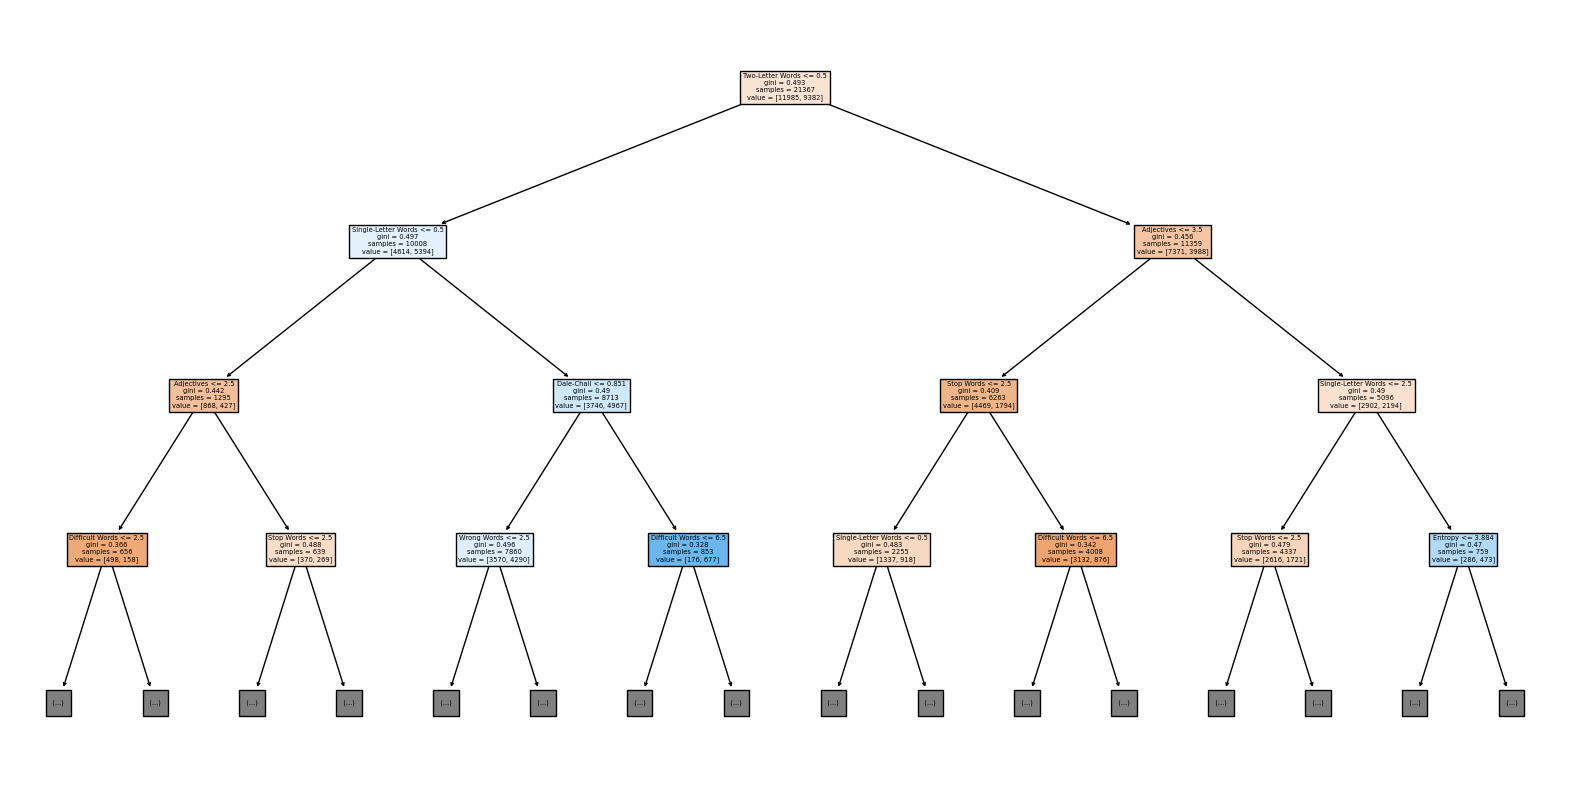

In [49]:
dt = model6.named_steps['decisiontreeclassifier']

plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, max_depth=3, feature_names=[
    'Entropy', 'Lexical Diversity', 'Dale-Chall', 'Flesch Ease', 'Stop Words',
    'Wrong Words', 'Difficult Words', 'Lengthy Words', 'Two-Letter Words',
    'Single-Letter Words', 'Verbs', 'Adjectives', 'Nouns'
])
plt.show()

## Cross Validation ##
Issue: takes very long time

#### Data Split ####

In [37]:
X = df['headline']
y = df['is_sarcastic']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Define model ####

In [38]:
linguistic_features = FunctionTransformer(extract_features)
model = make_pipeline(linguistic_features, DecisionTreeClassifier(max_depth=10, min_samples_split=50, max_leaf_nodes=100, random_state=42))

train_model(model4, X_train, y_train)
cv_f1 = cross_val_score(model, X_train_val, y_train_val, cv=10, scoring='f1')
print("Cross-validation F1 (mean):", cv_f1.mean())

train_model(model4, X_train_val, y_train_val)
train_f1 = f1_score(y_test, predict(model, X_test))
print("Training:", train_f1)

Cross-validation F1 (mean): 0.6375850500326148
Training: 0.6485546620299935
